# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')

import seaborn as sns
from matplotlib.pylab import plt
import time
import datetime

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Configurations

In [2]:
news_data = pd.read_csv('/kaggle/input/welfake/WELFake_Dataset.csv')

In [3]:
class_names = ['fake', 'real'] # 0: fake, 1: real

In [4]:
news_data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [6]:
news_data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [7]:
news_data = news_data.fillna('')

In [8]:
news_data.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [9]:
news_data.nunique()

Unnamed: 0    72134
title         62348
text          62719
label             2
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Count')

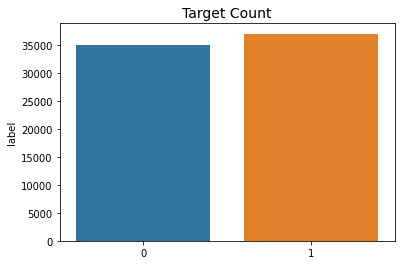

In [10]:
label_count = news_data.label.value_counts()
sns.barplot(label_count.index, label_count)
plt.title('Target Count', fontsize=14)

# 3. Building Dataset

### Stemming & Extracting text data using TF-IDF

In [11]:
port = PorterStemmer() # # reduces words to core origin 

def stemming(text):
    stem_text = re.sub('[^a-zA-Z]', ' ', text)
    stem_text = stem_text.lower()
    stem_text = stem_text.split()
    
    stem_text = [port.stem(word) for word in stem_text if not word in stopwords.words('english')]
    stem_text = ' '.join(stem_text)
    
    return stem_text

Since there are too many text data, we extracted only important words using TF-IDF.

In [12]:
def refinement_tfidf(text): # TF-IDF  # #
    ex = text.split('.')
    ex = pd.DataFrame(ex)[0].apply(stemming)
    
    if ex[0] == '':
        return text
    
    vectorizer = TfidfVectorizer()
    try:
        vectorizer.fit(ex)
        features = vectorizer.transform(ex)
    except:
        return text
    
    feature_names = np.array(vectorizer.get_feature_names())
    feature_count = features.toarray().mean(axis=0)
    
    refined_text = ' '.join(feature_names[feature_count > 0.05]) # setting the importance weights according to TF-IDF
    
    return refined_text

In [13]:
t0 = time.time()
news_data['refined_tfidf'] = news_data['text'].apply(refinement_tfidf)
print(time.time() - t0) # It takes long...

In [16]:
news_data['refined_tfidf'] = news_data['text']

In [17]:
news_data.head()

,Unnamed: 0,title,text,label,refined_tfidf
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,No comment is expected from Barack Obama Membe...
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"Now, most of the demonstrators gathered last ..."
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,A dozen politically active pastors came here f...
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"The RS-28 Sarmat missile, dubbed Satan 2, will..."


In [18]:
labels = news_data['label'].values
texts = (news_data['title'] + ' ' + news_data['refined_tfidf']).values

### Tokenization

In [19]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')  # # replacing sensitive info with tokens

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [20]:
idx = np.random.choice(range(len(texts)))
print(texts[idx])
# Tokenized
print(tokenizer.tokenize(texts[idx]))
# Token to Integral
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[idx])))

Republican senator hopes to kill class-action rule within weeks WASHINGTON (Reuters) - The U.S. Congress could act within weeks to kill a new rule that bars financial companies from blocking consumers who wish to file class-action lawsuits, according to a key Republican senator. Senator Tom Cotton, a member of the Senate Banking Committee writing legislation to tackle the rule, said Wednesday he was optimistic that Congress could pass a resolution revoking the new regulation authored by the Consumer Financial Protection Bureau (CFPB) within weeks. “I’m going to do all I can to repeal this regulation in the next three weeks of this congressional session,” he said at an event hosted by the U.S. Chamber of Commerce. Cotton is drafting legislation that would repeal the CFPB’s new ban on mandatory arbitration clauses often found in financial contracts. Under the Congressional Review Act, Congress can pass legislation repealing any new regulations with a simple majority.  Mandatory arbitrati

In [21]:
max_len = 0
id_len = []
for text in texts:
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    if len(input_ids) > 200:
        continue
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  200


<AxesSubplot:>

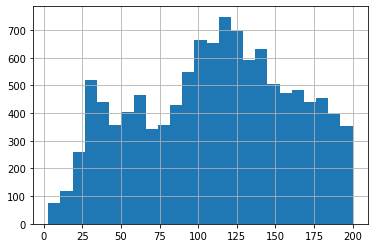

In [22]:
pd.Series(id_len).hist(bins=25)

In [23]:
def tokenize_map(sentence, labs='None'):
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:
        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens = True, # [CLS] & [SEP]
                            truncation = 'longest_first', # Control truncation
                            max_length = 100, # Max length about texts
                            pad_to_max_length = True, # Pad and truncate about sentences
                            return_attention_mask = True, # Attention masks
                            return_tensors = 'pt') # Return to pytorch tensors
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs != 'None':
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [24]:
input_ids, attention_masks, labels = tokenize_map(texts, labels)

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset.indices), len(val_dataset.indices)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(57707, 14427)

In [25]:
batch_size = 32
num_workers = 4

train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                shuffle=True,
                num_workers=num_workers)

val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=1,
                shuffle=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# 4. Loading Deep Learning Model

We used XLNet for natural language processing based on deep learning model.

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = XLNetForSequenceClassification.from_pretrained(
        'xlnet-base-cased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False)
model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

In [27]:
optimizer = torch.optim.AdamW(model.parameters(), # # + binary cross entropy
                              lr=6e-6,
                              eps=1e-8)

In [28]:
num_epochs = 1
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 5. Training

In [29]:
def get_acc(loader,dataset):
    score = 0
    predict = []
    groundT = []

    for i, (ids, masks, labels) in enumerate(loader):
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)

        g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
        pred = torch.max(g_labels, 1)[1][0].item()
        gt = labels[0].item()
        predict.append(pred)
        groundT.append(gt)
        score += int(pred == gt)

    avg = score / len(dataset)
    print('Accuracy: {:.4f}\n'.format(avg))
    return avg

In [38]:
model.train()
history=[]

total_step = len(train_loader)
for epoch in range(num_epochs):
    total_loss = 0
    for i, (ids, masks, labels) in enumerate(train_loader):
        
        ids = ids.to(device)
        masks = masks.to(device)
        labels = labels.to(device)
        
        loss = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        if (i+1) % 100 == 0:
            print('{} / {}'.format(batch_size*(i+1), train_dataset.__len__()))
            break
    print(get_acc(train_loader, train_dataset))
    history.append(get_acc(train_loader, train_dataset))
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, total_loss / total_step))
            
torch.save(model.state_dict(), '/kaggle/working/XLNet.ckpt')

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3200 / 57707
0.03041225501239018
Epoch: 1, Loss: 0.0048


# 6. Evaluation

In [31]:
torch.save(model.state_dict(), '/kaggle/working/XLNet.ckpt')

In [32]:
model.eval()
model.load_state_dict(torch.load('/kaggle/working/XLNet.ckpt', map_location=device))

<All keys matched successfully>

In [43]:
score = 0
predict = []
groundT = []

for i, (ids, masks, labels) in enumerate(val_loader):
    ids = ids.to(device)
    masks = masks.to(device)
    labels = labels.to(device)

    g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
    pred = torch.max(g_labels, 1)[1][0].item()
    gt = labels[0].item()
    predict.append(pred)
    groundT.append(gt)
    score += int(pred == gt)

avg = score / len(val_dataset)
print('Accuracy: {:.4f}\n'.format(avg))
print('Get acc: ' + str(get_acc(val_loader, val_dataset)))

Accuracy: 0.9714

Get acc: 0.9717196922437097


In [34]:
# def get_acc(loader,dataset):
#     score = 0
#     predict = []
#     groundT = []

#     for i, (ids, masks, labels) in enumerate(loader):
#         ids = ids.to(device)
#         masks = masks.to(device)
#         labels = labels.to(device)

#         g_labels = model(ids, token_type_ids=None, attention_mask=masks, labels=labels)[1]
    
#         pred = torch.max(g_labels, 1)[1][0].item()
#         gt = labels[0].item()
#         predict.append(pred)
#         groundT.append(gt)
#         score += int(pred == gt)

#     avg = score / len(dataset)ader,val_dataset))
    
#     return avg
        
# print(get_acc(val_lo

KeyboardInterrupt: 

It showed 97.50% performance!

# 7. Run Demo

In [35]:
for i in range(5):
    idx = np.random.choice(range(len(news_data)))

    print('\033[1m'+news_data['title'][idx]+'\n')
    print('\033[0m'+news_data['text'][idx])

    label = news_data['label'][idx]
    text = news_data['title'][idx] + ' ' + news_data['refined_tfidf'][idx]

    input_id, attention_mask = tokenize_map([text])

    g_label = model(input_id.to(device), token_type_ids=None, attention_mask=attention_mask.to(device))[0]
    pred = torch.max(g_label, 1)[1][0].item()

    print('\n')
    print('Predict: {}'.format(class_names[pred]))
    print('GT: {}'.format(class_names[label]))
    print('---------------------------------------------------------------------------------------------\n')

 Senate Republican Says Dumpster Fires Are More Popular Than Trump, Calls For Third Party Run

Nebraska Senator Ben Sasse seems to be fed up with his party, and there s no way in hell he s going to vote for Donald Trump. In a lengthy Facebook post, the Nebraska Senator called for a third party run to stop Trump. While he was certainly none too kind to Democratic frontrunner Hillary Clinton, he made it clear that his sights are set on stopping Trump from getting anywhere near the White House. Here is the embed of the post:Now, anyone with any sense regarding how our political process works knows that there s no way in hell a third party candidate can win in the current climate. In other words, if others jump ship like Senator Sasse has, the GOP throws the election to Clinton. Yep, you read that right. There is at least one senator in the Republican Party who is already openly willing to pursue a track that goes against his own party s nominee. That is how much he hates Trump.He isn t th

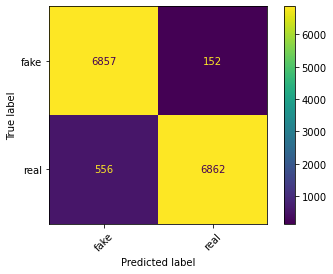

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = groundT
y_pred = predict

labels = class_names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.savefig('confusion.png', bbox_inches='tight')

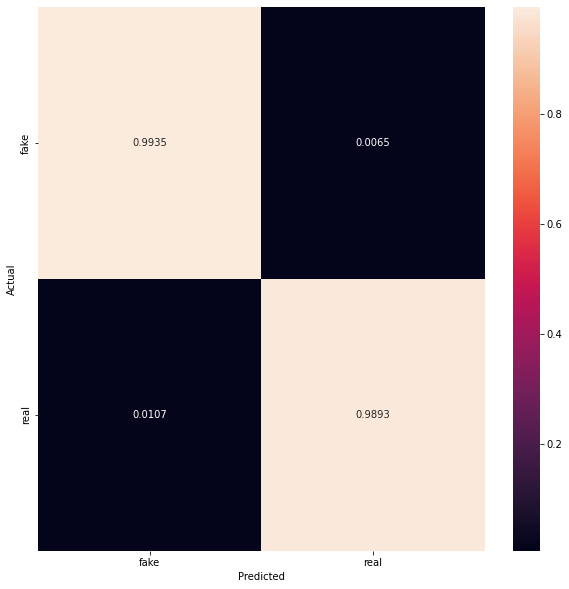

In [50]:
import seaborn as sns

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.4f', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

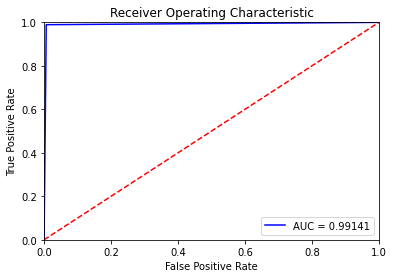

<Figure size 432x288 with 0 Axes>

In [51]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('ROC.png', bbox_inches='tight')


In [37]:
print(history)

[0.029805742804165872]


In [54]:
epoch_array = [i for i in range(1,num_epochs+1)]

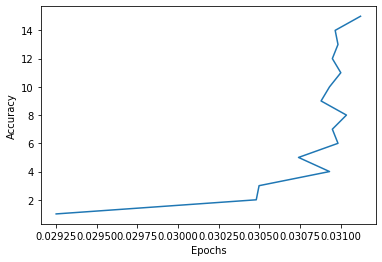

In [55]:
plt.plot(history, epoch_array)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, digits = 6))

              precision    recall  f1-score   support

           0   0.988586  0.993547  0.991061      6974
           1   0.993934  0.989266  0.991594      7453

    accuracy                       0.991336     14427
   macro avg   0.991260  0.991407  0.991327     14427
weighted avg   0.991349  0.991336  0.991336     14427



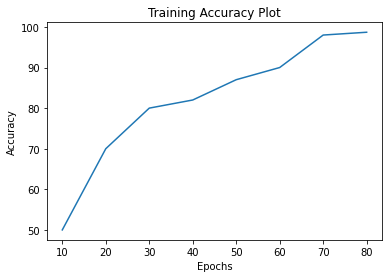

In [57]:
import matplotlib.pyplot as plt
acc_array = [50,70,80,82,87,90,98,98.69]
epoch_array = [i*10 for i in range(1, len(acc_array)+1)]
plt.plot(epoch_array,acc_array)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Plot")
plt.savefig('fake.png',bbox_inches='tight')

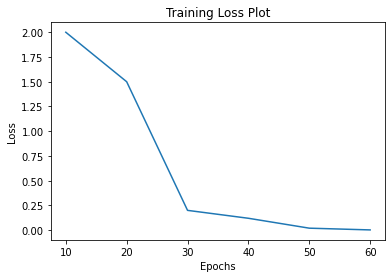

In [58]:
import matplotlib.pyplot as plt
acc_array = [2,1.5,0.2,0.12,0.02,0.0024]
epoch_array = [i*10 for i in range(1, len(acc_array)+1)]
plt.plot(epoch_array,acc_array)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Plot")
plt.savefig('fake_loss.png',bbox_inches='tight')

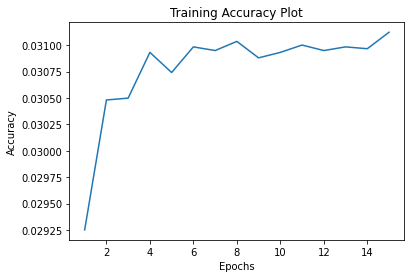

In [59]:
import matplotlib.pyplot as plt
acc_array = history
epoch_array = [i for i in range(1, len(acc_array)+1)]
plt.plot(epoch_array,acc_array)
plt.xlabel("Epochs")
plt.ylabel("HG")
plt.title("Training Accuracy Plot")
plt.savefig('fake.png',bbox_inches='tight')